# A Credit Card Dataset for Machine Learning!

## Context

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

## Task

Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task.

In [193]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from scipy.stats import skew,norm


In [293]:
# load data

app_record = pd.read_csv('data/application_record.csv')
credit_record = pd.read_csv('data/credit_record.csv')

In [195]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):        
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
#                  color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', weight='bold')
    plt.xlabel('Predicted label', weight='bold')

In [301]:
def draw_countfig(data,x,hue=None, figs_num=1, figsize=(20,5), title1="", title2="",rotation = 90,order=None, legend_loc='upper right'):
    if figs_num == 2:
        f, ax = plt.subplots(1,2, figsize=(20,5))
        ax1 = sns.countplot(x=data[x], order=order, ax=ax[0]);
        ax2 = sns.countplot(x=x, hue=hue, data=data, order=order);
        plt.legend(loc='upper right')
        plt.xticks(rotation=rotation)
        ax1.title.set_text(title1)
        ax2.title.set_text(title2)
        plt.show()
    elif (figs_num==1) & (hue != None):
        plt.figure(figsize=figsize)
        ax = sns.countplot(x=data[x], data=data, hue=hue);        
        ax.bar_label(ax.containers[0])
        ax.bar_label(ax.containers[1])
        ax.set_title(title1)
        plt.legend(loc='upper right')
        plt.xticks(rotation=rotation)
        plt.show()
    elif figs_num==1:
        plt.figure(figsize=figsize)
        ax = sns.countplot(x=data[x], data=data);        
        ax.bar_label(ax.containers[0])
        ax.set_title(title1)
        plt.xticks(rotation=rotation)
        plt.show()

# Dealing with Credit Record DataFrame

In [302]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [303]:
credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [304]:
print(app_record['ID'].nunique())
print(credit_record['ID'].nunique())

438510
45985


In [305]:
# get the intersection
len(set(app_record["ID"]).intersection(set(credit_record['ID'])))

36457

In [306]:
credit_record.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


## Dealing with the target variable

In [307]:
credit_record['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

0: 1-29 days past due

1: 30-59 days past due 

2: 60-89 days overdue 

3: 90-119 days overdue 

4: 120-149 days overdue 

5: Overdue or bad debts, write-offs for more than 150 days 

C: paid off that month 

X: No loan for the month

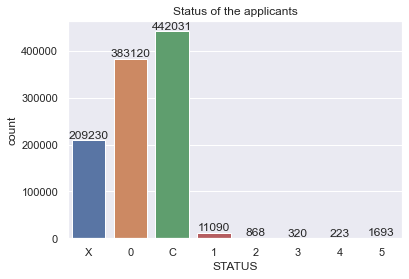

In [308]:
fig_title = "Status of the applicants"
draw_countfig(credit_record,x='STATUS', figsize=(6,4), rotation=0,title1=fig_title)

**It is clear from the figure that clients that have a past due problems are very small.**


I suggest to: 

Users who overdue for more than 60 days as target risk users (Bad Users).

Other Users will be considered as Good Users

Bad Users marked as '1' and Good Ones are '0'.

STATUS with labels 2,3,4,5 will be 1 as Bad 
STATUS with labels C,X,0,1 will be 0 as Good


In [309]:
credit_record['label'] = None

credit_record['label'][credit_record['STATUS'] =='2'] = '1' 
credit_record['label'][credit_record['STATUS'] =='3'] = '1' 
credit_record['label'][credit_record['STATUS'] =='4'] = '1' 
credit_record['label'][credit_record['STATUS'] =='5'] = '1' 

credit_record['label'][credit_record['STATUS'] =='0'] = '0' 
credit_record['label'][credit_record['STATUS'] =='1'] = '0' 
credit_record['label'][credit_record['STATUS'] =='X'] = '0' 
credit_record['label'][credit_record['STATUS'] =='C'] = '0' 

In [310]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS,label
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [311]:
# get the start month which is the smallest value of MONTHS_BALANCE
# is the month when loan was granted

start_mnth_df = credit_record.groupby('ID')["MONTHS_BALANCE"].agg(min).reset_index()
start_mnth_df.head()

,ID,MONTHS_BALANCE
0,5001711,-3
1,5001712,-18
2,5001713,-21
3,5001714,-14
4,5001715,-59


In [312]:
start_mnth_df = start_mnth_df.rename(columns={'MONTHS_BALANCE':'start_month'}) 
new_credit_df = pd.merge(credit_record, start_mnth_df, how="left", on="ID") # merge to record data
new_credit_df.head()

,ID,MONTHS_BALANCE,STATUS,label,start_month
0,5001711,0,X,0,-3
1,5001711,-1,0,0,-3
2,5001711,-2,0,0,-3
3,5001711,-3,0,0,-3
4,5001712,0,C,0,-18


In [313]:
new_credit_df['start_month'] = new_credit_df['start_month'] * -1
new_credit_df.head()

,ID,MONTHS_BALANCE,STATUS,label,start_month
0,5001711,0,X,0,3
1,5001711,-1,0,0,3
2,5001711,-2,0,0,3
3,5001711,-3,0,0,3
4,5001712,0,C,0,18


In [314]:
new_credit_df = pd.DataFrame(new_credit_df.groupby(['ID'])['label'].agg(max)).reset_index()
new_credit_df.head()

,ID,label
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [315]:
new_credit_df.shape

(45985, 2)

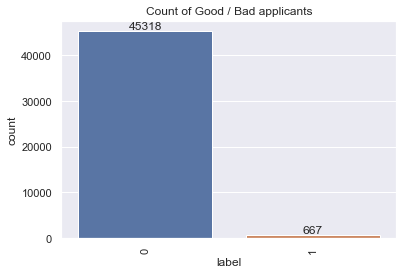

In [370]:
draw_countfig(new_credit_df, x='label', figs_num=1, title1='Count of Good / Bad applicants',figsize=(6,4))

# Dealing with Application Record DataFrame

In [316]:
app_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [317]:
app_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [318]:
app_record.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [319]:
app_record.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [320]:
# check if there are any duplicates in the dataframe

print("the number of duplicats: ", app_record.iloc[:,1:].duplicated().sum())
print("The percentage of duplicates: ", np.round(100 * app_record.iloc[:,1:].duplicated().sum() / app_record.shape[0], 1), "%")

the number of duplicats:  348472
The percentage of duplicates:  79.5 %


In [321]:
# Drop duplicates
app_record = app_record.drop_duplicates(subset = app_record.columns[1:], keep='first')
app_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0


In [322]:
app_record.shape

(90085, 18)

In [323]:
app_record.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        27477
CNT_FAM_MEMBERS            0
dtype: int64

In [324]:
app_record['OCCUPATION_TYPE'].unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [325]:
app_record['OCCUPATION_TYPE'].value_counts()

Laborers                 16624
Sales staff               9123
Core staff                8091
Managers                  6675
Drivers                   5860
High skill tech staff     3357
Accountants               3034
Medicine staff            2484
Cooking staff             1764
Security staff            1740
Cleaning staff            1222
Private service staff      750
Low-skill Laborers         569
Secretaries                412
Waiters/barmen staff       393
Realty agents              218
HR staff                   167
IT staff                   125
Name: OCCUPATION_TYPE, dtype: int64

In [326]:
# Filling the missing values
app_record['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

In [327]:
app_record.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64

In [328]:
app_record.shape

(90085, 18)

In [329]:
data_df = pd.merge(app_record, new_credit_df, how='inner', on='ID')
data_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Other,2.0,0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,Other,1.0,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,0


In [330]:
data_df.shape

(9709, 19)

In [331]:
data_df.iloc[:,1:].duplicated().sum()

0

# Exploratory Data Analysis

In [332]:
data_df['AGE_YEARS'] = - data_df['DAYS_BIRTH']/365
data_df.drop('DAYS_BIRTH', axis=1, inplace=True)

C:\Users\ahmed\anaconda3\envs\py38ai\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


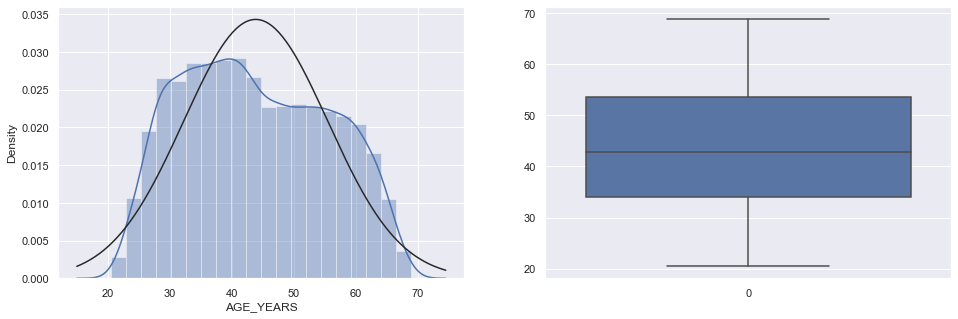

In [333]:
f,ax = plt.subplots(1,2,figsize=(16,5))
sns.distplot(data_df['AGE_YEARS'],fit=norm,ax=ax[0], bins=20)
sns.boxplot(data=data_df['AGE_YEARS'])
plt.show()

In [334]:
# As there are many unemployment applicants we will create unemployed indicator

data_df['UNEMPLOYED']=0
data_df.loc[- data_df['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1

# Create years employed feature
data_df['YEARS_EMPLOYED'] = - data_df['DAYS_EMPLOYED'] / 365  # make positive and divide by 365 to convert into years

data_df.loc[data_df['YEARS_EMPLOYED'] < 0,'YEARS_EMPLOYED'] = 0
data_df.drop('DAYS_EMPLOYED', axis=1, inplace=True)

C:\Users\ahmed\anaconda3\envs\py38ai\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


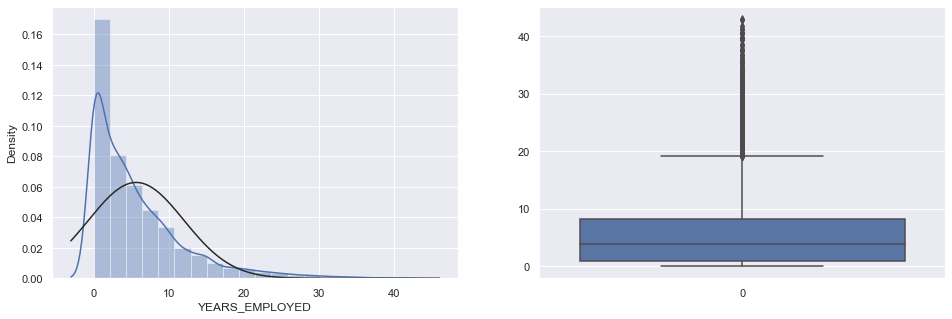

In [335]:
f,ax = plt.subplots(1,2,figsize=(16,5))
sns.distplot(data_df['YEARS_EMPLOYED'],fit=norm,ax=ax[0], bins=20)
sns.boxplot(data=data_df['YEARS_EMPLOYED'])
plt.show()

From the distribution figure, we can see that YEARS_EMPLOYED variable is not normally distributed.

The distribution is very skew to right as there some years larger than 40 years of employment.

From the box plot, it is clear that there are a data points that can be considered as outliers.

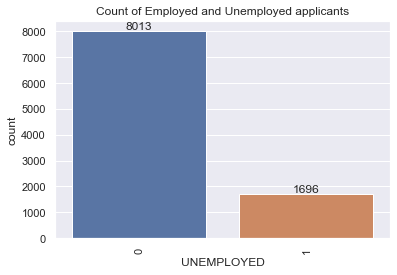

In [336]:
draw_countfig(data_df, x='UNEMPLOYED', figs_num=1, title1='Count of Employed and Unemployed applicants',figsize=(6,4))

**Encode binary features to numeric values**

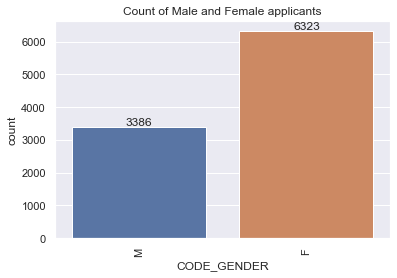

In [337]:
draw_countfig(data_df, x='CODE_GENDER', figs_num=1, title1='Count of Male and Female applicants',figsize=(6,4))

From the figure, It is clear that the number of Female Applicants is nearly double the number of Male Applicants

In [338]:
data_df["CODE_GENDER"] =  data_df["CODE_GENDER"].replace(['F','M'], [0, 1])

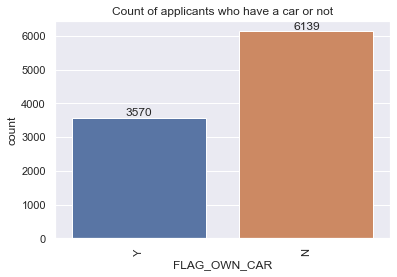

In [339]:
draw_countfig(data_df, x='FLAG_OWN_CAR', figs_num=1, title1='Count of applicants who have a car or not',figsize=(6,4))

From the figure, It is clear that the number of Applicants who have not cars are nearly double the number of applicants who have.

In [340]:
data_df["FLAG_OWN_CAR"] = data_df["FLAG_OWN_CAR"].replace(["Y","N"], [1, 0])

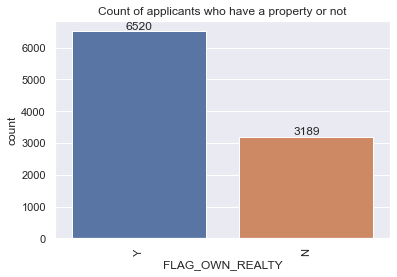

In [341]:
draw_countfig(data_df, x='FLAG_OWN_REALTY', figs_num=1, title1='Count of applicants who have a property or not',figsize=(6,4))

From the figure, It is clear that the number of Applicants who have a property are nearly double the number of applicants who have not.

In [342]:
# Encode binary features to numeric values
data_df["FLAG_OWN_REALTY"] = data_df["FLAG_OWN_REALTY"].replace(["Y", "N"], [1, 0])

In [343]:
data_df['FLAG_MOBIL'].unique()

array([1], dtype=int64)

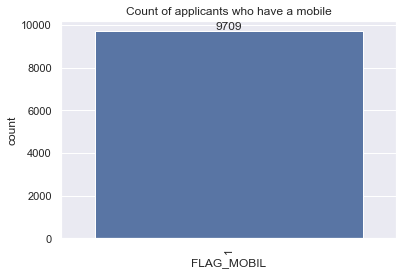

In [344]:
draw_countfig(data_df, x='FLAG_MOBIL', figs_num=1, title1='Count of applicants who have a mobile',figsize=(6,4))

The feature of having a mobile phone is considered as a constant feature, we can drop it. As it will not affect the prediction state.

In [345]:
data_df.drop(['FLAG_MOBIL'], axis=1, inplace=True)

In [346]:
data_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label,AGE_YEARS,UNEMPLOYED,YEARS_EMPLOYED
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Other,2.0,0,32.890411,0,12.443836
1,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,0,58.832877,0,3.106849
2,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,0,52.356164,0,8.358904
3,5008812,0,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Other,1.0,0,61.545205,1,0.000000
4,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2.0,0,46.224658,0,2.106849


In [347]:
data_df['FLAG_EMAIL'].unique()

array([0, 1], dtype=int64)

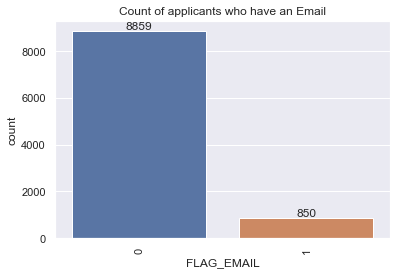

In [348]:
draw_countfig(data_df, x='FLAG_EMAIL', figs_num=1, title1='Count of applicants who have an Email',figsize=(6,4))

In [349]:
data_df['CNT_CHILDREN'].unique()

array([ 0,  1,  3,  2,  4,  5, 14, 19,  7], dtype=int64)

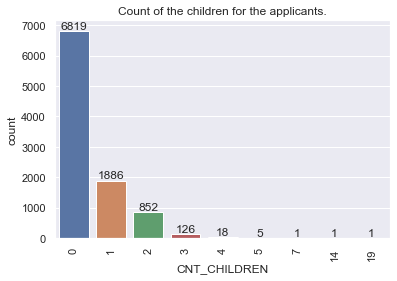

In [350]:
draw_countfig(data_df, x='CNT_CHILDREN', figs_num=1, title1='Count of the children for the applicants.',figsize=(6,4))

C:\Users\ahmed\anaconda3\envs\py38ai\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


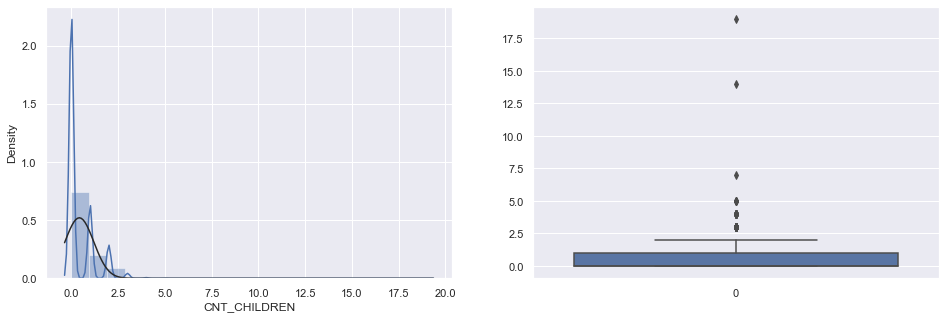

In [351]:
f,ax = plt.subplots(1,2,figsize=(16,5))
sns.distplot(data_df['CNT_CHILDREN'],fit=norm,ax=ax[0], bins=20)
sns.boxplot(data=data_df['CNT_CHILDREN'])
plt.show()

C:\Users\ahmed\anaconda3\envs\py38ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


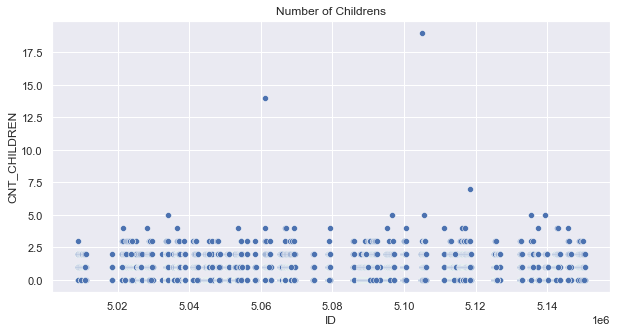

In [352]:
plt.figure(figsize=(10,5))
plt.title('Number of Childrens')
sns.scatterplot(data_df['ID'], data_df['CNT_CHILDREN'])
plt.show()

In [353]:
data_df[data_df["CNT_CHILDREN"] > 3].shape

# drop the outliers from the number of children feature
data_df.drop(data_df[data_df["CNT_CHILDREN"] > 3].index, axis=0, inplace=True)

C:\Users\ahmed\anaconda3\envs\py38ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


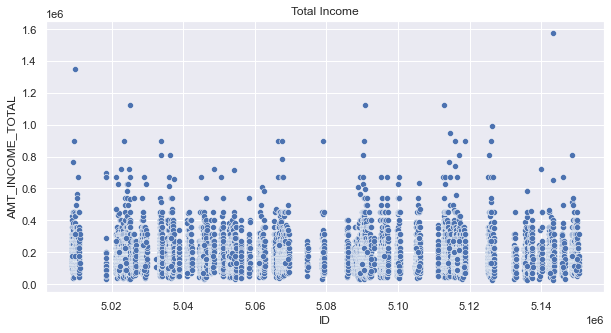

In [354]:
plt.figure(figsize=(10,5))
plt.title('Total Income')
sns.scatterplot(data_df['ID'], data_df['AMT_INCOME_TOTAL'])
plt.show()

C:\Users\ahmed\anaconda3\envs\py38ai\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


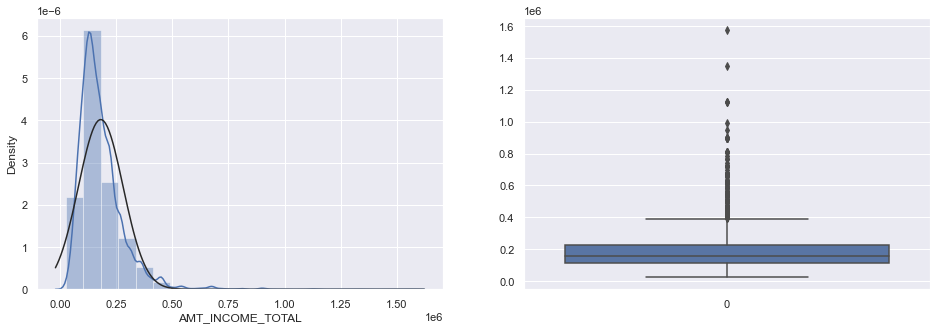

In [355]:
f,ax = plt.subplots(1,2,figsize=(16,5))
sns.distplot(data_df['AMT_INCOME_TOTAL'],fit=norm,ax=ax[0], bins=20)
sns.boxplot(data=data_df['AMT_INCOME_TOTAL'])
plt.show()

From the distribution figure, we can see that AMT_INCOME_TOTAL variable is not normally distributed.

The distribution is very skew to right.

From the box plot, it is clear that there are a data points that can be considered as outliers.

In [356]:
print(data_df[data_df['AMT_INCOME_TOTAL'] > 800000].shape)
print(data_df[data_df['AMT_INCOME_TOTAL'] > 600000].shape)

(23, 19)
(71, 19)


In [357]:
# drop the samples where the income more than 800000
data_df.drop(data_df[data_df['AMT_INCOME_TOTAL'] > 800000].index, axis=0, inplace=True)

In [358]:
data_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'label', 'AGE_YEARS', 'UNEMPLOYED', 'YEARS_EMPLOYED'],
      dtype='object')

In [359]:
data_df['NAME_INCOME_TYPE'].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

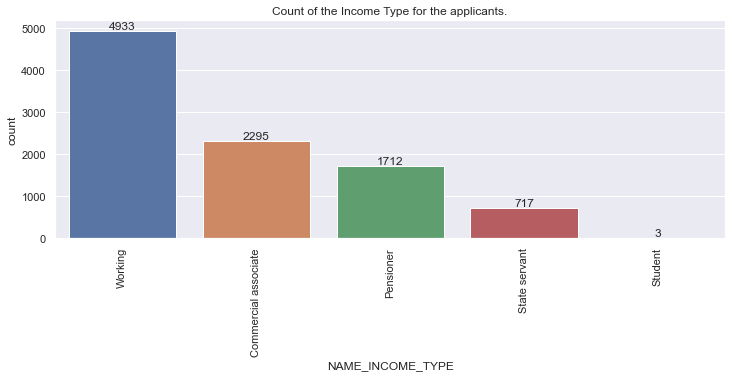

In [360]:
draw_countfig(data_df, x='NAME_INCOME_TYPE', figs_num=1, title1='Count of the Income Type for the applicants.',figsize=(12,4))

In [361]:
data_df[data_df['NAME_INCOME_TYPE'] == 'Student']

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label,AGE_YEARS,UNEMPLOYED,YEARS_EMPLOYED
280,5010456,0,0,1,0,171000.0,Student,Higher education,Married,House / apartment,0,0,1,Core staff,2.0,0,51.386301,0,10.695890
1202,5025088,1,0,0,0,135000.0,Student,Higher education,Single / not married,With parents,0,0,1,Other,1.0,0,24.972603,0,1.591781
3143,5047796,0,0,1,1,112500.0,Student,Secondary / secondary special,Civil marriage,House / apartment,0,0,0,Laborers,3.0,0,33.224658,0,2.178082


## Relationship between Target variable and Features variables

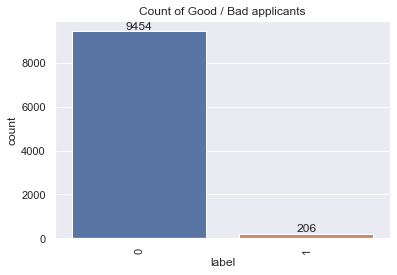

In [371]:
draw_countfig(data_df, x='label', figs_num=1, title1='Count of Good / Bad applicants',figsize=(6,4))

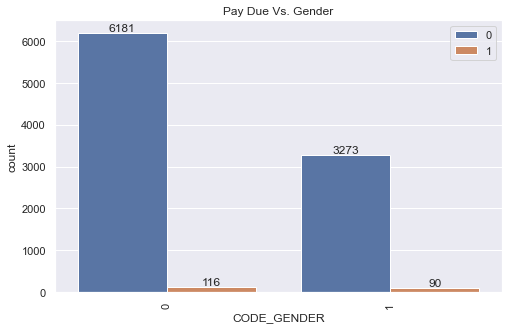

In [362]:
fig_title = "Pay Due Vs. Gender"
draw_countfig(data=data_df, x='CODE_GENDER', hue='label', title1=fig_title, figsize=(8,5))

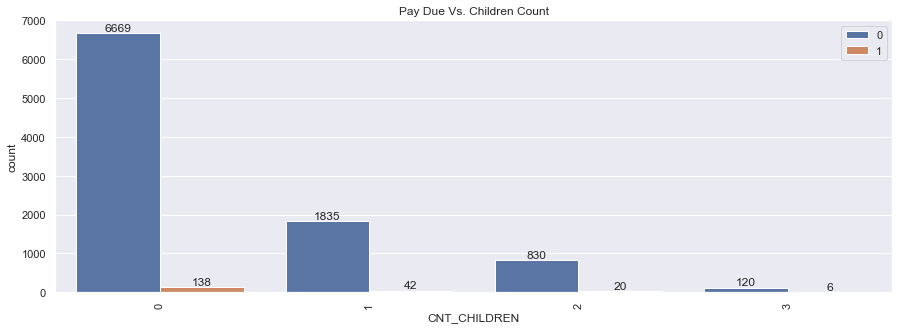

In [363]:
fig_title = "Pay Due Vs. Children Count"
draw_countfig(data=data_df, x='CNT_CHILDREN', hue='label', title1=fig_title, figsize=(15,5))

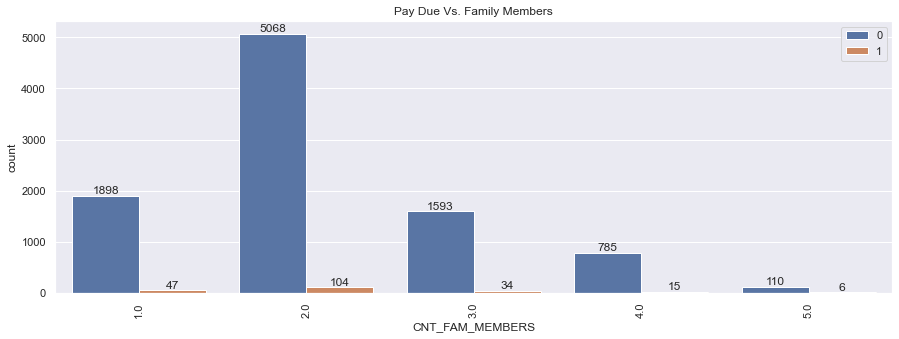

In [364]:
fig_title = "Pay Due Vs. Family Members"
draw_countfig(data=data_df, x='CNT_FAM_MEMBERS', hue='label', title1=fig_title, figsize=(15,5))

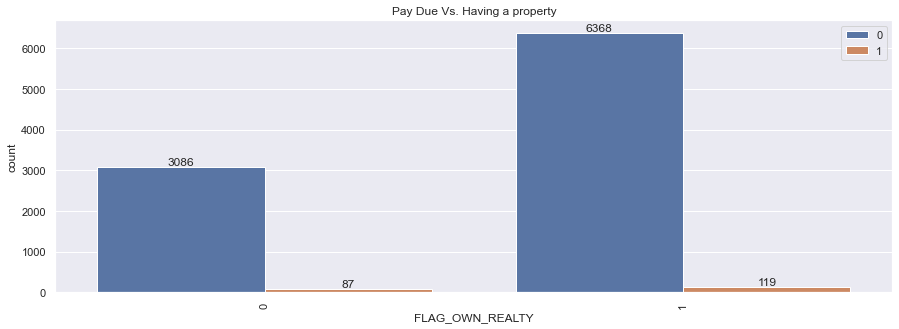

In [365]:
fig_title = "Pay Due Vs. Having a property"
draw_countfig(data=data_df, x='FLAG_OWN_REALTY', hue='label', title1=fig_title, figsize=(15,5))

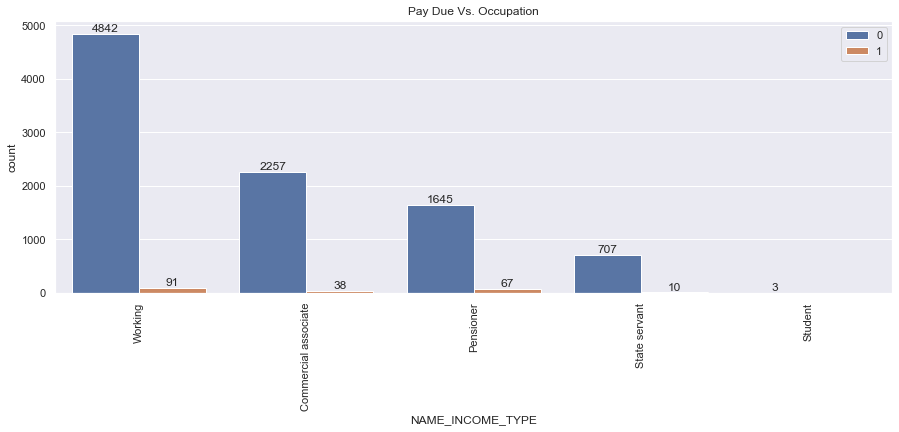

In [366]:
fig_title = "Pay Due Vs. Occupation"
draw_countfig(data=data_df, x='NAME_INCOME_TYPE', hue='label', title1=fig_title, figsize=(15,5))

In [367]:
data_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'label', 'AGE_YEARS', 'UNEMPLOYED', 'YEARS_EMPLOYED'],
      dtype='object')

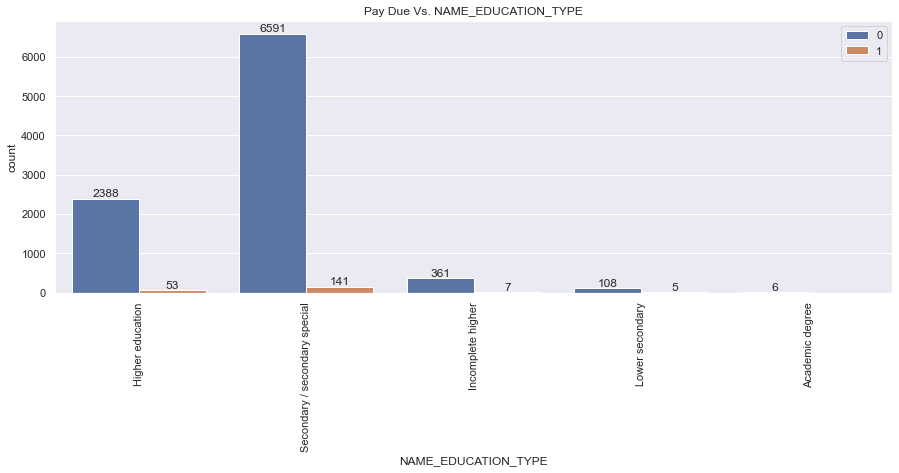

In [368]:
fig_title = "Pay Due Vs. NAME_EDUCATION_TYPE"
draw_countfig(data=data_df, x='NAME_EDUCATION_TYPE', hue='label', title1=fig_title, figsize=(15,5))

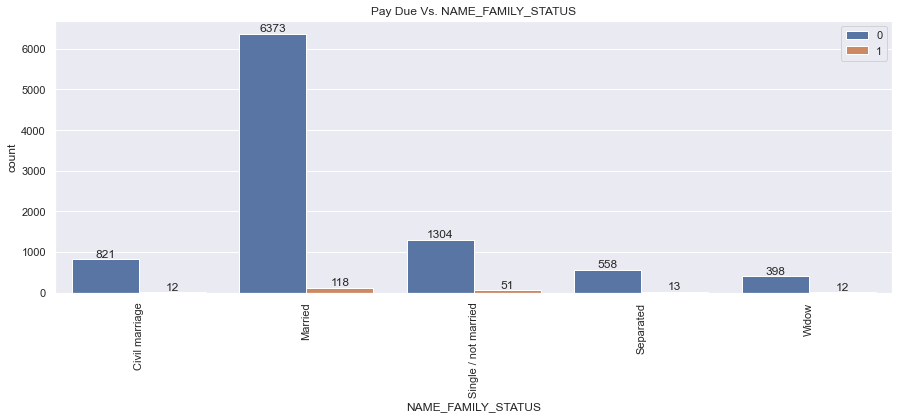

In [373]:
fig_title = "Pay Due Vs. NAME_FAMILY_STATUS"
draw_countfig(data=data_df, x='NAME_FAMILY_STATUS', hue='label', title1=fig_title, figsize=(15,5))

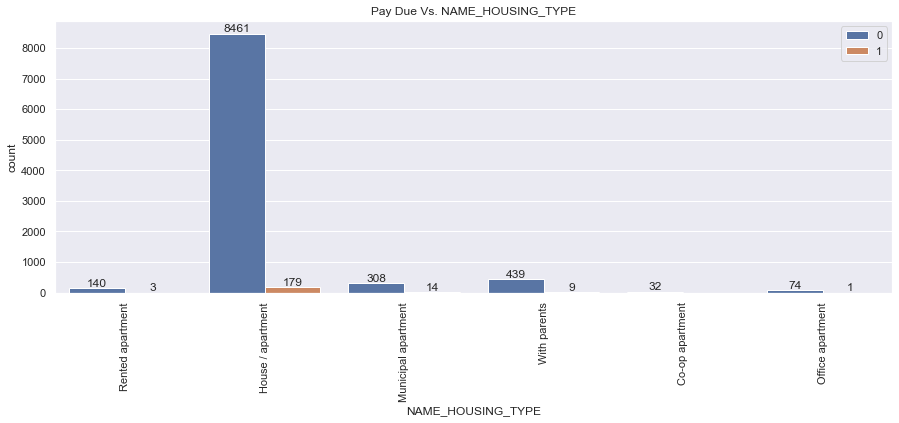

In [377]:
fig_title = "Pay Due Vs. NAME_HOUSING_TYPE"
draw_countfig(data=data_df, x='NAME_HOUSING_TYPE', hue='label', title1=fig_title, figsize=(15,5))

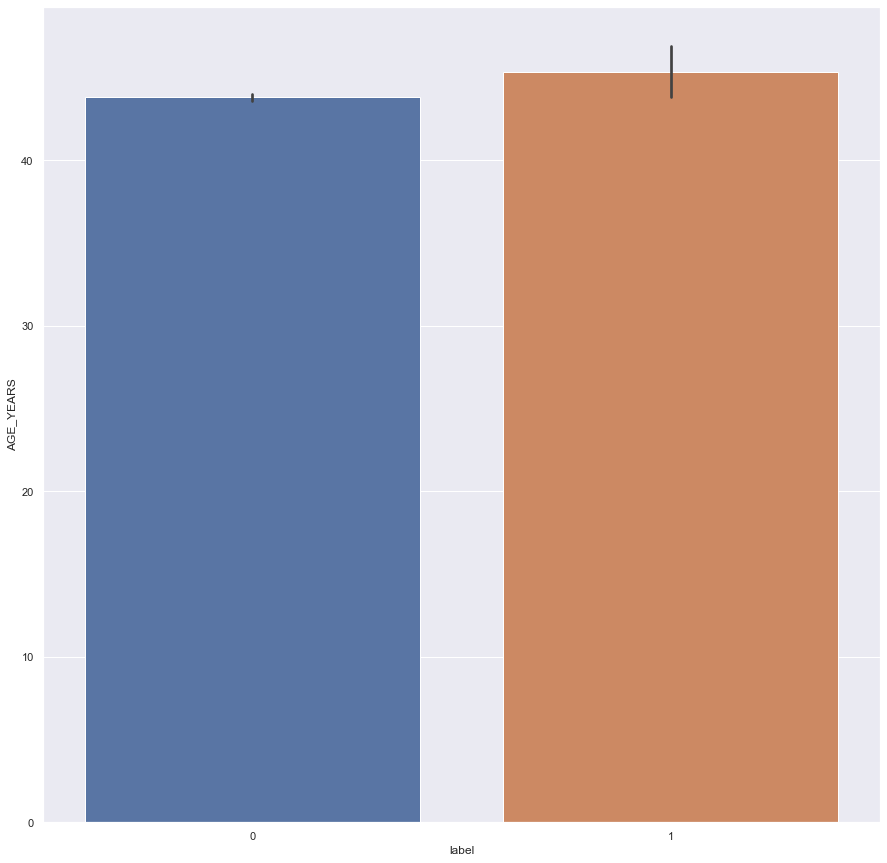

In [379]:
ax = sns.barplot(x="label", y="AGE_YEARS", data=data_df)

In [188]:
def creating_dummy_variable(df, columns) :
    
    # Creating a dummy variable for some of the categorical variables and dropping the first one.
    dummy1 = pd.get_dummies(df[columns], drop_first=True)
    
    # Adding the results to the master dataframe
    df1 = pd.concat([df, dummy1], axis=1)
    
    #Dropping the initial column
    df1.drop(columns, axis = 1, inplace = True)
    
    return df1

In [189]:
data_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label,AGE_YEARS,UNEMPLOYED,YEARS_EMPLOYED
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Other,2.0,0,32.890411,0,12.443836
1,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58.832877,0,3.106849
2,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.356164,0,8.358904
3,5008812,0,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Other,1.0,0,61.545205,1,0.000000
4,5008815,1,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,1,Accountants,2.0,0,46.224658,0,2.106849


In [190]:
test_data_df = creating_dummy_variable(data_df, ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','OCCUPATION_TYPE'])

In [191]:
test_data_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,label,AGE_YEARS,UNEMPLOYED,YEARS_EMPLOYED,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,5008804,1,1,1,0,427500.0,1,1,0,0,2.0,0,32.890411,0,12.443836,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5008806,1,1,1,0,112500.0,1,0,0,0,2.0,0,58.832877,0,3.106849,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5008808,0,0,1,0,270000.0,1,0,1,1,1.0,0,52.356164,0,8.358904,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,5008812,0,0,1,0,283500.0,1,0,0,0,1.0,0,61.545205,1,0.000000,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5008815,1,1,1,0,270000.0,1,1,1,1,2.0,0,46.224658,0,2.106849,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [192]:
labels = test_data_df['label']
features = test_data_df.drop(['label','ID'], axis=1)

# Training The ML models

In [65]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [66]:
class_names = ["Bad", "Good"]

In [67]:
labels.value_counts()

0    9454
1     206
Name: label, dtype: int64

In [68]:
X_balance, Y_balance = SMOTE().fit_resample(features, labels)

X_balance = pd.DataFrame(X_balance, columns = features.columns)

In [69]:
X_balance.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE_YEARS,UNEMPLOYED,YEARS_EMPLOYED,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,1,1,1,0,427500.0,1,1,0,0,2.0,32.890411,0,12.443836,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0,112500.0,1,0,0,0,2.0,58.832877,0,3.106849,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,270000.0,1,0,1,1,1.0,52.356164,0,8.358904,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,283500.0,1,0,0,0,1.0,61.545205,1,0.000000,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,1,0,270000.0,1,1,1,1,2.0,46.224658,0,2.106849,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
Y_balance.value_counts()

0    9454
1    9454
Name: label, dtype: int64

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_balance, Y_balance, test_size=0.2)

In [72]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

Accuracy Score is 0.55605


Normalized confusion matrix
[[0.49628055 0.50371945]
 [0.38473684 0.61526316]]


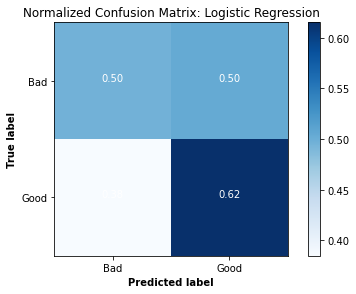

In [73]:
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

In [80]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))


Accuracy Score is 0.9413
      0     1
0  1753   129
1    93  1807


Normalized confusion matrix
[[0.9314559  0.0685441 ]
 [0.04894737 0.95105263]]


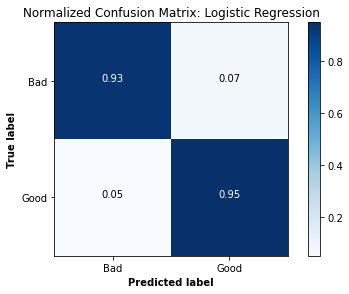

In [81]:
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

In [82]:
model.feature_importances_

array([1.50646842e-02, 1.51743330e-02, 4.83469093e-02, 1.94297789e-02,
       5.75620592e-02, 0.00000000e+00, 4.05774421e-02, 7.40850633e-05,
       0.00000000e+00, 2.23009734e-01, 6.01552962e-02, 0.00000000e+00,
       2.66162753e-02, 2.00454094e-03, 2.38212883e-02, 0.00000000e+00,
       1.52143751e-02, 4.94225406e-02, 1.83584228e-02, 9.74672027e-03,
       2.29835320e-02, 1.31590426e-01, 4.53591219e-02, 3.45603072e-02,
       4.64022110e-02, 4.58894076e-03, 2.13983712e-03, 3.07607391e-04,
       0.00000000e+00, 3.49688415e-03, 3.82062361e-04, 3.71920048e-03,
       7.19837686e-05, 8.99133997e-03, 2.67685667e-04, 1.73966847e-04,
       0.00000000e+00, 2.52327264e-02, 0.00000000e+00, 4.59450714e-03,
       0.00000000e+00, 1.37701197e-02, 3.14431155e-05, 0.00000000e+00,
       2.50660062e-02, 0.00000000e+00, 1.53939301e-03, 1.52213083e-04])

In [ ]:
sns.set(rc = {'figure.figsize':(15,15)})

In [88]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    p = sns.scatterplot(x = 'Score',y='Name', linewidth = 0, data = imp,s = point_size,
                        color='red').set(xlabel='importance', ylabel='features')

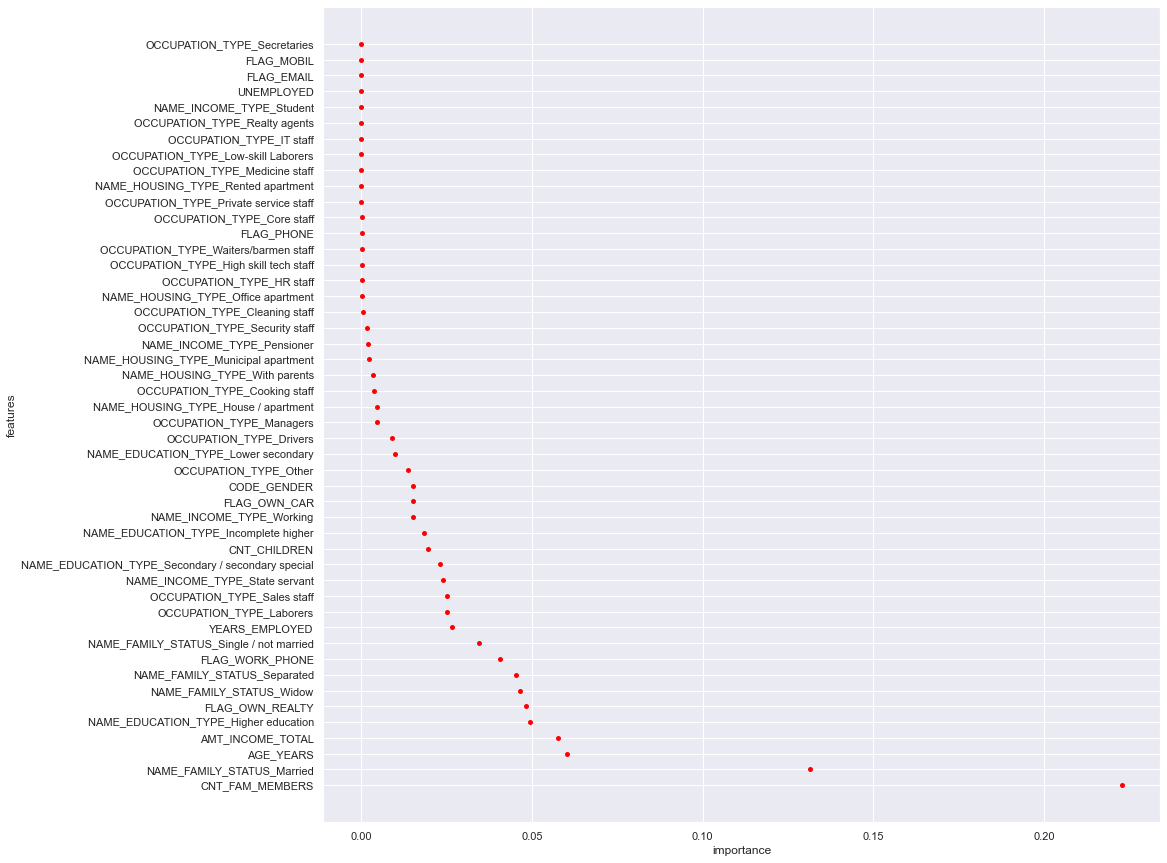

In [104]:
plot_importance(model, X_train,25) 